# **TFM**

Librerías

In [ ]:
!pip install stanza
!python -m spacy download es_core_news_sm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 43.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu1

In [ ]:
import spacy
import stanza
import csv
import re
import pandas as pd
from sklearn.metrics import classification_report
stanza.download('es')

INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Downloading default packages for language: es (Spanish) ...


INFO:stanza:Downloaded file to /root/stanza_resources/es/default.zip
INFO:stanza:Finished downloading models and saved to /root/stanza_resources


POS tagging con spaCy

In [ ]:
nlp_spacy = spacy.load("es_core_news_sm")

with open("documentos.txt", encoding="utf-8") as file:
    text = file.read()

doc_spacy = nlp_spacy(text)

with open("anotaciones_SPACY.csv", "w", encoding="utf-8", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["Token", "POS", "Género", "Número"])
    for token in doc_spacy:
        token_text = token.text.strip()
        if token_text and not token.is_space:
            genero = ", ".join(token.morph.get("Gender")) if token.morph.get("Gender") else ""
            numero = ", ".join(token.morph.get("Number")) if token.morph.get("Number") else ""
            writer.writerow([token_text, token.pos_, genero, numero])

POS tagging con Stanza

In [ ]:
nlp_stanza = stanza.Pipeline('es', processors='tokenize,pos', tokenize_pretokenized=True, use_gpu=False, verbose=False)

with open("documentos.txt", encoding="utf-8") as file:
    text = file.read()

tokens = re.findall(r'\w+|[^\w\s]', text, re.UNICODE)
corrected_tokens = []
i = 0
while i < len(tokens):
    if tokens[i].lower() == 'de' and i + 1 < len(tokens) and tokens[i + 1].lower() == 'el':
        corrected_tokens.append('del')
        i += 2
    elif tokens[i].lower() == 'a' and i + 1 < len(tokens) and tokens[i + 1].lower() == 'el':
        corrected_tokens.append('al')
        i += 2
    else:
        corrected_tokens.append(tokens[i])
        i += 1

doc_stanza = nlp_stanza([corrected_tokens])

def extraer_rasgo(feats, rasgo):
    if feats:
        for feat in feats.split("|"):
            if feat.startswith(rasgo + "="):
                return feat.split("=")[1]
    return ""

with open("anotaciones_STANZA.csv", "w", encoding="utf-8", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["Token", "POS", "Género", "Número"])
    for sentence in doc_stanza.sentences:
        for word in sentence.words:
            token_text = word.text
            feats = word.feats
            genero = extraer_rasgo(feats, "Gender")
            numero = extraer_rasgo(feats, "Number")
            writer.writerow([token_text, word.pos, genero, numero])

In [ ]:
anotaciones_GOLD = pd.read_csv('anotaciones_GOLD.csv', sep=';')
anotaciones_GOLD.head()

,Token,POS,Género,Número
0,Este,DET,Masc,Sing
1,documento,NOUN,Masc,Sing
2,contiene,VERB,NaN,Sing
3,un,DET,Masc,Sing
4,breve,ADJ,NaN,Sing


COMPARACIÓN

In [ ]:
archivos = [
    'anotaciones_GOLD.csv',
    'anotaciones_STANZA.csv',
    'anotaciones_SPACY.csv'
]

conteo_filas = {}

for archivo in archivos:
    try:
        df = pd.read_csv(archivo, sep=';')
        conteo_filas[archivo] = len(df)
    except Exception as e:
        conteo_filas[archivo] = f"Error: {e}"

print("Cantidad de filas por archivo:")
for archivo, filas in conteo_filas.items():
    print(f"{archivo}: {filas}")

Cantidad de filas por archivo:
anotaciones_GOLD.csv: 49946
anotaciones_STANZA.csv: 49946
anotaciones_SPACY.csv: 49946


In [ ]:
gold = pd.read_csv("anotaciones_GOLD.csv", sep=';', header=0, names=["token", "pos", "genero", "numero"])
spacy = pd.read_csv("anotaciones_SPACY.csv", sep=';', header=None, skiprows=1, names=["token", "pos", "genero", "numero"])
stanza_df = pd.read_csv("anotaciones_STANZA.csv", sep=';', header=None, skiprows=1, names=["token", "pos", "genero", "numero"])

gold = gold.rename(columns={"pos": "gold_pos", "genero": "gold_genero", "numero": "gold_numero"})
spacy = spacy.rename(columns={"pos": "spacy_pos", "genero": "spacy_genero", "numero": "spacy_numero"})
stanza_df = stanza_df.rename(columns={"pos": "stanza_pos", "genero": "stanza_genero", "numero": "stanza_numero"})

gold = gold.reset_index(drop=True)
spacy = spacy.reset_index(drop=True)
stanza_df = stanza_df.reset_index(drop=True)

result = pd.DataFrame({
    "token": gold["token"],
    "gold_pos": gold["gold_pos"],
    "gold_genero": gold["gold_genero"],
    "gold_numero": gold["gold_numero"],
    "spacy_pos": spacy["spacy_pos"],
    "spacy_genero": spacy["spacy_genero"],
    "spacy_numero": spacy["spacy_numero"],
    "stanza_pos": stanza_df["stanza_pos"],
    "stanza_genero": stanza_df["stanza_genero"],
    "stanza_numero": stanza_df["stanza_numero"]
})

result = result.fillna("-")

result[:11]

,token,gold_pos,gold_genero,gold_numero,spacy_pos,spacy_genero,spacy_numero,stanza_pos,stanza_genero,stanza_numero
0,Este,DET,Masc,Sing,DET,Masc,Sing,DET,Masc,Sing
1,documento,NOUN,Masc,Sing,NOUN,Masc,Sing,NOUN,Masc,Sing
2,contiene,VERB,-,Sing,VERB,-,Sing,VERB,-,Sing
3,un,DET,Masc,Sing,DET,Masc,Sing,DET,Masc,Sing
4,breve,ADJ,-,Sing,ADJ,-,Sing,ADJ,-,Sing
5,resumen,NOUN,Masc,Sing,NOUN,Masc,Sing,NOUN,Masc,Sing
6,de,ADP,-,-,ADP,-,-,ADP,-,-
7,este,DET,Masc,Sing,DET,Masc,Sing,DET,Masc,Sing
8,estudio,NOUN,Masc,Sing,NOUN,Masc,Sing,NOUN,Masc,Sing
9,para,ADP,-,-,ADP,-,-,ADP,-,-


In [ ]:
result.to_csv('dataframe_anotado.csv', index=False)

In [ ]:
attributes = ['pos', 'genero', 'numero']

for attr in attributes:
    gold_attr = result[f"gold_{attr}"].astype(str)
    spacy_attr = result[f"spacy_{attr}"].astype(str)
    stanza_attr = result[f"stanza_{attr}"].astype(str)
    print(f"Reporte de clasificación para {attr} (gold vs spacy):")
    print(classification_report(gold_attr, spacy_attr, zero_division=0))
    print(f"Reporte de clasificación para {attr} (gold vs stanza):")
    print(classification_report(gold_attr, stanza_attr, zero_division=0))
    print("=" * 54)

Reporte de clasificación para pos (gold vs spacy):
              precision    recall  f1-score   support

         ADJ       0.93      0.89      0.91      5073
         ADP       1.00      1.00      1.00      7217
         ADV       0.94      0.96      0.95      1300
         AUX       0.59      0.93      0.72       739
       CCONJ       0.99      1.00      1.00      1433
         DET       0.99      0.98      0.99      5101
        INTJ       0.00      0.00      0.00         0
        NOUN       0.97      0.80      0.87     12957
         NUM       0.92      0.93      0.92      1139
        PART       0.00      0.00      0.00         0
        PRON       0.91      0.93      0.92      2030
       PROPN       0.09      0.86      0.16       321
       PUNCT       1.00      0.96      0.98      7959
       SCONJ       0.95      0.87      0.91       532
         SYM       0.91      0.83      0.87        95
        VERB       0.89      0.82      0.85      4036
           X       1.00      0

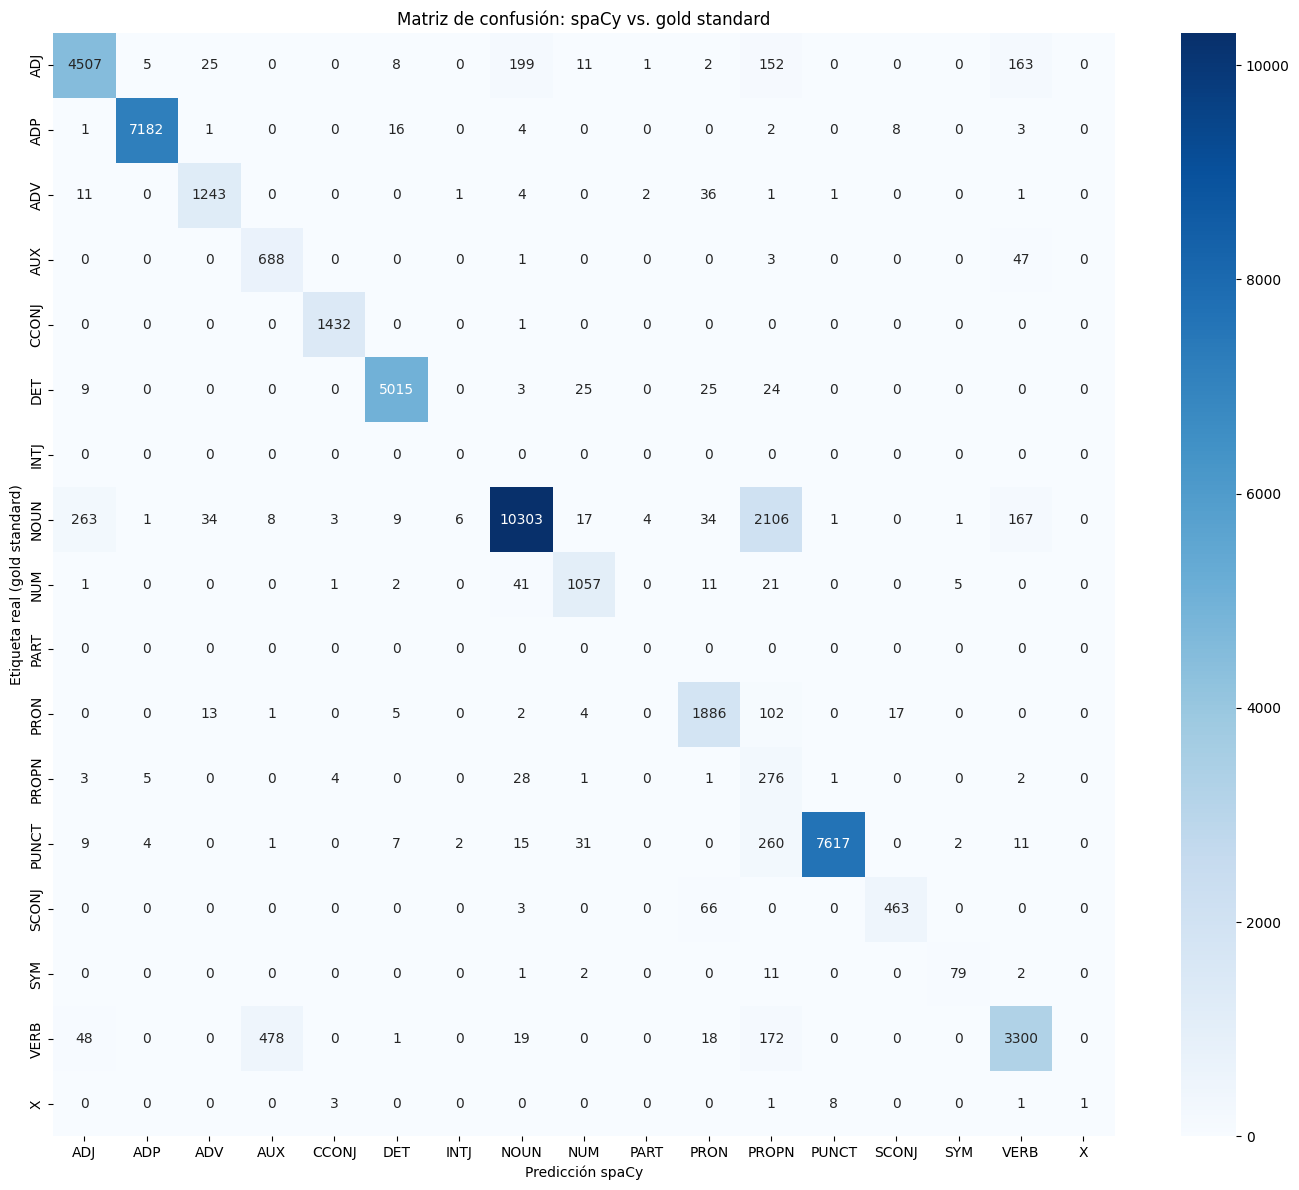

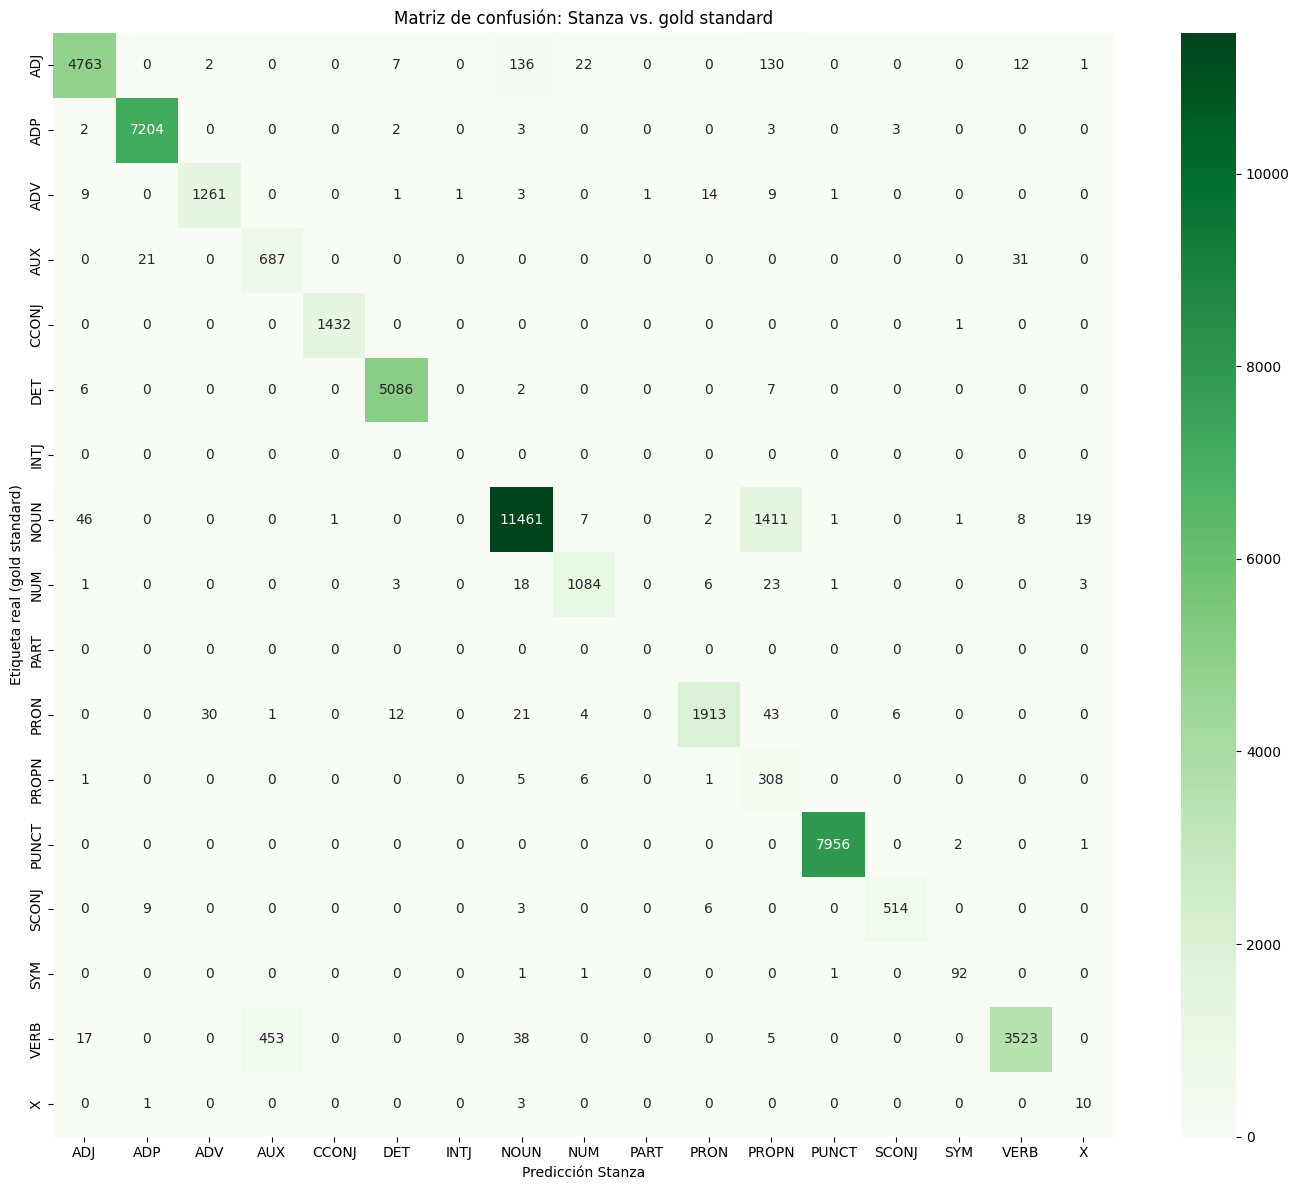

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

gold_df = pd.read_csv("anotaciones_GOLD.csv", sep=";")
spacy_df = pd.read_csv("anotaciones_SPACY.csv", sep=";")
stanza_df = pd.read_csv("anotaciones_STANZA.csv", sep=";")

df = pd.DataFrame({
    "gold_pos": gold_df["POS"],
    "spacy_pos": spacy_df["POS"],
    "stanza_pos": stanza_df["POS"]
})

labels = sorted(set(df["gold_pos"]) | set(df["spacy_pos"]) | set(df["stanza_pos"]))

cm_spacy = confusion_matrix(df["gold_pos"], df["spacy_pos"], labels=labels)
plt.figure(figsize=(14, 12))
sns.heatmap(cm_spacy, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicción spaCy")
plt.ylabel("Etiqueta real (gold standard)")
plt.title("Matriz de confusión: spaCy vs. gold standard")
plt.tight_layout()
plt.show()

cm_stanza = confusion_matrix(df["gold_pos"], df["stanza_pos"], labels=labels)
plt.figure(figsize=(14, 12))
sns.heatmap(cm_stanza, annot=True, fmt="d", cmap="Greens", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicción Stanza")
plt.ylabel("Etiqueta real (gold standard)")
plt.title("Matriz de confusión: Stanza vs. gold standard")
plt.tight_layout()
plt.show()